<a href="https://colab.research.google.com/github/JuniorHZ19/HerramientasIA/blob/main/RSRGAN2.5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip DIV2K_train_HR.zip # This is our dataset link. I will include this command in the description

In [ ]:
#@markdown # *0) ** Instalando libreria(OBLIGATORIO)

!pip install torch torchvision torchaudio


In [1]:
#@markdown # *1) ** Clase Para manejo de directorios de datasets de imagenes


import os
import cv2
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
# Recorre el directorio  y elmiina los archvios que no tiene las extensioens permitidas

class DataSetManage:




 def comprobar_ext_directorios(self,directorio):

  for clase,[directorio,etiquetas] in(directorio.items()):
   lista_directorio=os.listdir(directorio)
   self._validarExt(directorio)



 def  _validarExt(self,directorio):
  print(directorio)
   # Extensiones permitidas
  extensiones_permitidas = {".jpg", ".jpeg", ".png"}
  for root, dirs, files in os.walk(directorio):

    for file in files:
        # Obtiene la extensión del archivo
        _, extension = os.path.splitext(file)

        # Verifica si la extensión no está en la lista de extensiones permitidas y elimina el archivo
        if extension.lower() not in extensiones_permitidas:
            archivo_a_eliminar = os.path.join(root, file)
            os.remove(archivo_a_eliminar)
            print(f"Se eliminó: {archivo_a_eliminar}")


# Cambia nombre de cada archivo dentro del directorio a un valor secuencial

 def cambiar_nombres_directorios(self,directorio):
   for clase,[directorio,etiquetas] in(directorio.items()):
     lista_directorio=os.listdir(directorio)
     self._cambiarNombre(directorio,clase)
     print(directorio)


 def _cambiarNombre(self,directorios,subfijo):
  archivos_en_directorio = os.listdir(directorios)
  for i, archivo in enumerate(archivos_en_directorio, start=1):
    # Construir el nuevo nombre del archivo
    nuevo_nombre = f"{subfijo}{i}{os.path.splitext(archivo)[1]}"

    # Ruta completa del archivo antiguo y nuevo
    ruta_antigua = os.path.join(directorios, archivo)
    ruta_nueva = os.path.join(directorios, nuevo_nombre)

    # Cambiar el nombre del archivo
    os.rename(ruta_antigua, ruta_nueva)
    print(f"Se cambió el nombre de {ruta_antigua} a {ruta_nueva}")


#Obtiene la cantidad de elemntos que tiene la carpeta

 def len_directorio(self,directorio):
    cantidad_elementos = sum(1 for elemento in os.listdir(directorio) if os.path.isfile(os.path.join(directorio, elemento)))
    return cantidad_elementos


#----------------------------------------------------------------------------------------------

#Valida si la imagen se puede leer usando  pill o cv2 si no se puede leer se elimina

 def validar_Img_Pill(self,directorio,):
  for etiqueta,[directorio,clase] in(directorio.items()):

    lista_paths=os.listdir(directorio)
    self._validarLecturaImgPill(directorio,lista_paths)
  print(f"Se ah validado todas las imagenes")

 def validar_Img_cv2(self,directorio):
  for etiqueta,[directorio,clase] in(directorio.items()):

    lista_paths=os.listdir(directorio)
    self._validarLecturaImg(directorio,lista_paths)
  print(f"Se ah validado todas las imagenes")

 def _validarLecturaImg(self,directorio,lista):

  for ruta in(lista):
   imagen=cv2.imread(directorio+ruta)
   if  imagen is None:
     os.remove(directorio+ruta)
     print(f"No se pudo leer y se elimino archivo:{directorio+ruta}")

 def _validarLecturaImgPill(self,directorio,lista):
    for ruta in(lista):
     try:
      imagen=Image.open(directorio+ruta)
     except Exception as e:
      os.remove(directorio+ruta)
      print(f"Archivo '{directorio+ruta}' eliminado.")



#vamos a recorrer el dicionario y validar ruta por ruta si se puede leer sino se elminara
#vamos guaradno al mismo tiempo 3 listas, los directorios , listas de paths de los directiros y de las clases ,para usarlo luego usarlo al crear el csv

 def separar_datos_directorios(self,directorios):
  listas_directorios=[]
  listas_listas_directorios=[]
  listas_clases=[]

  for etiqueta,[directorio,clase] in(directorios.items()):

       lista_paths=os.listdir(directorio)
       listas_directorios.append(directorio)
       listas_listas_directorios.append(lista_paths)
       listas_clases.append(clase)

  return listas_directorios,listas_listas_directorios,listas_clases

 def emparejar_listas_paths(self,lista_listas):

   #Tomamos el minimo tamaño dentro de las lista de cada clase
   tamaño_minimo = min(len(arr) for arr in lista_listas)

   #Vamos a emparejar todas las listas con un tamaño igual que sea la del minimo tamaño de todas,esto para tener un set de datos parejo por cada clase
   Reducido_lista_paths=[]

   #Reduce cada lista de los paths a la cantidad minimo para que todos tenga iaugal cantidad
   for listas in(lista_listas):
    Reducido_lista_paths.append(listas[:tamaño_minimo])

   return Reducido_lista_paths
#---------------------------------------------------------------------------------


 def crear_paths_csv(self,directorio_base,lista_paths,clases,nombre_archivo):

   columnas=["path","etiqueta"]
   datos_csv=[]

   for dir_base,dir_path,clase in  zip(directorio_base,lista_paths,clases):

    for path  in (dir_path):

     datos_csv.append([dir_base+path ,clase])


   df_lista=pd.DataFrame(datos_csv,columns=columnas)
   df_lista=df_lista.sort_values(by='path')
   df_lista.to_csv(nombre_archivo,index=False)
   print("Csv Creado")
#---------------------------------------------------------------------------------

#devuelve cuatnos elemtnos tiene cada clase
 def total_elementos(self,directorio,csv_path):
    df=pd.read_csv(csv_path)
    for clase,[directorio,etiqueta] in (directorio.items()):
     tamaño_etiqueta=(df["etiqueta"] == etiqueta).sum()
     print(f"la clase {clase} tiene :{tamaño_etiqueta} elementos")


#-------------------------------------------------------------------------------------------------

  #Funciones para data aumentation
 def   data_aumentation_conjunto(self,input_imagen_folder,output_path_folder,iteraciones,transformaciones):  #ingresa trnasformacioens como compose donde se aplicara las trasnfomracioens conjutnos pero se repteira un numero de veces por cada imagen

   for filename in os.listdir(input_imagen_folder):

    if filename.endswith('.jpg') or filename.endswith('.png'):

        input_path = os.path.join(input_imagen_folder, filename)
        output_path = os.path.join(output_path_folder, f'{filename}')
        # Aplica las transformaciones
        print(output_path)
        self._apply_transfomaciones_conjunto_it(input_path,output_path,int(iteraciones),transformaciones)


 def   data_aumentation_individual(self,input_imagen_folder,output_path_folder,transformaciones):  #las trnasfomaciones solo pasaremos la lista ya que ira aplicando la transformacion una por una por cada imagen

  for filename in os.listdir(input_imagen_folder):

    if filename.endswith('.jpg') or filename.endswith('.png'):
        input_path = os.path.join(input_imagen_folder, filename)
        output_path = os.path.join(output_path_folder, f'{filename}')

        # Aplica las transformaciones
        self._apply_transfomaciones_conjunto(input_path,output_path,transformaciones)



 def _apply_transfomaciones_conjunto_it(self,input_imagen_path,output_iamgen_path,iteraciones,transformations=None,): #aplica las transfomracioens  conjutas por iteracion y se guarda las iamgenes

   imagen=Image.open(input_imagen_path)


   for i in range(iteraciones):
      imagen_trasformada=transformations(imagen)

      out_root, out_extension = os.path.splitext(output_iamgen_path)
      imagen_trasformada.save(f"{out_root}{out_extension}")


 def _apply_transfomaciones_conjunto(self,input_imagen_path,output_iamgen_path,transformations=None): #aplica las transfomracioens individuales  y se guarda las iamgenes

  imagen=Image.open(input_imagen_path)

  for i,transformacion in enumerate(transformations):
   imagen_transformada=transformacion(imagen)
   out_root, out_extension = os.path.splitext(output_iamgen_path)
   imagen_transformada.save(f"{out_root}{out_extension}")



In [3]:


#Creamos las carpetas con las imagenes en hr y lw

#Creamos los arhcivo baja resolucion aparitr de imangenes alta resoulcion en hr , estos archios iran a carpaeta lw
directorio_in="/content/DIV2K_train_HR"
directorio_out_lw="/content/lw/"
directorio_out_hr="/content/hr/"

#antes de otrogar mediads de hr y lw , chekea como el generador va votando las resolucioens hr_fake segun la resolucion lw que especifics tiene qeu conicidr
#ya que el discriminador necsita la misma medidades tanto para el hr y el hr_fake que genera el generador

transformaciones_hr=transforms.Compose([
transforms.RandomCrop(size=(80, 80)),

])


transformaciones_lw=transforms.Compose([
transforms.Resize((20,20),interpolation=transforms.InterpolationMode.BICUBIC),
])



datasetmanage=DataSetManage()
datasetmanage.data_aumentation_conjunto(directorio_in,directorio_out_hr,10,transformaciones_hr)
datasetmanage.data_aumentation_conjunto(directorio_out_hr,directorio_out_lw,1,transformaciones_lw)
sorted(directorio_out_hr)
sorted(directorio_out_lw)


/content/hr/hr_39.png
/content/hr/hr_17.png
/content/hr/hr_11.png
/content/hr/hr_22.png
/content/hr/hr_25.png
/content/hr/hr_13.png
/content/hr/hr_47.png
/content/hr/hr_34.png
/content/hr/hr_6.png
/content/hr/hr_5.png
/content/hr/hr_42.png
/content/hr/hr_14.png
/content/hr/hr_15.png
/content/hr/hr_20.png
/content/hr/hr_40.png
/content/hr/hr_41.png
/content/hr/hr_27.png
/content/hr/hr_30.png
/content/hr/hr_4.png
/content/hr/hr_49.png
/content/hr/hr_2.png
/content/hr/hr_38.png
/content/hr/hr_3.png
/content/hr/hr_32.png
/content/hr/hr_45.png
/content/hr/hr_8.png
/content/hr/hr_0.png
/content/hr/hr_44.png
/content/hr/hr_18.png
/content/hr/hr_28.png
/content/hr/hr_29.png
/content/hr/hr_10.png
/content/hr/hr_37.png
/content/hr/hr_35.png
/content/hr/hr_24.png
/content/hr/hr_43.png
/content/hr/hr_31.png
/content/hr/hr_16.png
/content/hr/hr_12.png
/content/hr/hr_7.png
/content/hr/hr_19.png
/content/hr/hr_1.png
/content/hr/hr_36.png
/content/hr/hr_46.png
/content/hr/hr_23.png
/content/hr/hr_48.p

['/', '/', '/', 'c', 'e', 'l', 'n', 'n', 'o', 't', 't', 'w']

In [4]:

dmg=DataSetManage()
directoriolw={
     "lw":["/content/lw/",0],
}

directoriohr={
     "hr":["/content/hr/",1],
}




listas_directorios,listas_paths_directorios,listas_clases=dmg.separar_datos_directorios(directoriolw)
Dataset_csv="lw_dataset.csv" #nombre que tenda nuestlo csv
dmg.crear_paths_csv(listas_directorios,listas_paths_directorios,listas_clases,Dataset_csv)


listas_directorios,listas_paths_directorios,listas_clases=dmg.separar_datos_directorios(directoriohr)
Dataset_csv="hr_dataset.csv" #nombre que tendla nuestlo csv
dmg.crear_paths_csv(listas_directorios,listas_paths_directorios,listas_clases,Dataset_csv)




Csv Creado
Csv Creado


In [ ]:
#DEFNIIR DISPOSITIVO:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA está disponible.")
    device = torch.device("cuda")
else:
    print("CUDA no está disponible. Se utilizará la CPU.")
    device = torch.device("cpu")

CUDA está disponible.


In [ ]:
#@markdown # *2) ** Creacion de clase DATASET(OBLIGATORIO)
import torch
from torch.utils.data import Dataset,DataLoader
import pandas as pd
import numpy as np
import cv2
from PIL import Image


class MiDataSet(Dataset):

  def __init__(self,csv_file, transform=None):


     self.data=pd.read_csv(csv_file)

     self.x=self.data["path"]
     self.y=self.data["etiqueta"]

     self.transform=transform

     self.samples=self.data["path"].shape[0]

  def __getitem__(self,id):

    rut_imagen=self.x[id]
    imagen=cv2.imread(rut_imagen)
    etiqueta=self.y[id]


    if imagen is None:
      pillow_image = Image.open(rut_imagen)
      numpy_image = np.array(pillow_image)
      imagen=cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)


    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)


    if self.transform:
      imagen_rgb = self.transform(imagen_rgb)

    return imagen_rgb,etiqueta


  def __len__(self):
   return self.samples





torch.Size([3, 80, 80])


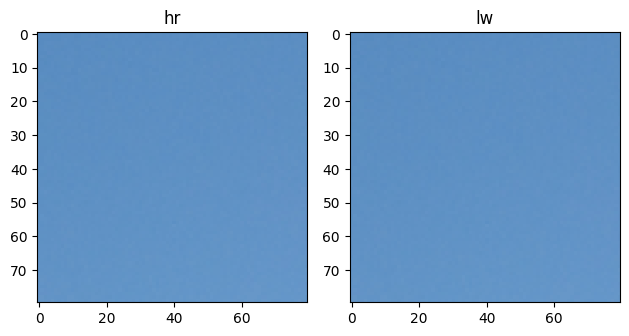

In [ ]:
#CREANDO DATASETS Y DATALOADERS:

import numpy as np
import matplotlib.pyplot as plt

transformaciones = transforms.Compose([
    transforms.ToTensor(),

])

batch_size=15

DatasetLw=MiDataSet("/content/lw_dataset.csv",transformaciones)
data_loaderLw=DataLoader(DatasetLw,batch_size=batch_size)

DatasetHr=MiDataSet("/content/hr_dataset.csv",transformaciones)
data_loaderHr=DataLoader(DatasetHr,batch_size=batch_size)

generated_image_hr,etiqueta_hr=DatasetHr.__getitem__(200)
generated_image_lw,etiqueta_lw=DatasetHr.__getitem__(200)
print(generated_image_hr.shape)
generated_image_np_hr = generated_image_hr.squeeze().permute(1, 2, 0).numpy()
generated_image_np_lw = generated_image_lw.squeeze().permute(1, 2, 0).numpy()
# Visualizar la imagen generada
# Subfigura 1
plt.subplot(1, 2, 1)
plt.imshow(generated_image_np_hr)
plt.title('hr')

# Subfigura 2
plt.subplot(1, 2, 2)
plt.imshow(generated_image_np_lw)
plt.title('lw')

# Ajustar diseño
plt.tight_layout()

# Mostrar las imágenes
plt.show()

In [ ]:
#@markdown # *0) ** Creando clase Discriminadora y Geneaadora:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

class Discriminator (nn.Module):
  def __init__(self):
   super(Discriminator,self).__init__()

   self.conv1=nn.Conv2d(3,64,kernel_size=3,stride=1, bias=False)
   self.conv2=nn.Conv2d(64,64,kernel_size=3,stride=2, bias=False)
   self.btchnorm64=nn.BatchNorm2d(64)

   self.conv3=nn.Conv2d(64,128,kernel_size=3,stride=1, bias=False)
   self.conv4=nn.Conv2d(128,128,kernel_size=3,stride=2, bias=False)
   self.btchnorm128=nn.BatchNorm2d(128)

   self.conv5=nn.Conv2d(128,256,kernel_size=3,stride=1, bias=False)
   self.conv6=nn.Conv2d(256,256,kernel_size=3,stride=2, bias=False)
   self.btchnorm256=nn.BatchNorm2d(256)

   self.conv7=nn.Conv2d(256,512,kernel_size=3,stride=1, bias=False)
   self.conv8=nn.Conv2d(512,512,kernel_size=3,stride=2, bias=False)
   self.btchnorm512=nn.BatchNorm2d(512)
   self.flatt=nn.Flatten()

   self.oculta1=nn.LazyLinear(1024)
   self.salida= nn.LazyLinear(1)


  def forward(self,x):

    x=self.conv1(x)
    x= nn.LeakyReLU(0.1)(x)

    x=self.conv2(x)
    x=self.btchnorm64(x)
    x= nn.LeakyReLU(0.1)(x)

    x=self.conv3(x)
    x=self.btchnorm128(x)
    x= nn.LeakyReLU(0.1)(x)

    x=self.conv4(x)
    x=self.btchnorm128(x)
    x= nn.LeakyReLU(0.1)(x)

    x=self.conv5(x)
    x=self.btchnorm256(x)
    x= nn.LeakyReLU(0.1)(x)

    x=self.conv6(x)
    x=self.btchnorm256(x)
    x= nn.LeakyReLU(0.1)(x)

    x=self.conv7(x)
    x=self.btchnorm512(x)
    x= nn.LeakyReLU(0.1)(x)

    x=self.conv8(x)
    x=self.btchnorm512(x)
    x= nn.LeakyReLU(0.1)(x)

    x=self.flatt(x)
    x=self.oculta1(x)
    x= nn.LeakyReLU(0.1)(x)

    x=self.salida(x)
    out=torch.sigmoid(x)

    return out







In [ ]:
discriminador=Discriminator()
discriminador=discriminador.to(device)
x=torch.randn(20,3,208,208).to(device)

print(discriminador(x))

In [ ]:
#------------------------------------------------------------------------
import torch.nn.functional as F
class Generador(nn.Module):

  def __init__(self,factor_escala):
   super(Generador,self).__init__()

   self.convInicial=nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1)

  #Bloques residuales

   rrdb_blocks = []

   for _ in range(3):

    rrdb_blocks.append(RRD_Block(64,32))

   self.dense_net= nn.Sequential(*rrdb_blocks)

   self.convSalida1=nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1)


  #vamos a obligar que la salida anterior se ajuste a la entrada del bloque umsampling que es 256/factor al cuadrado, asi no tengamos problemas en el bluque

   self.convextra=nn.Conv2d(64,int(256),kernel_size=1,stride=1)

  #Bloques upsampling

   upsampling = []
   for out_features in range(factor_escala):
        upsampling.append(interpole_block(256))

   self.upsampling = nn.Sequential(*upsampling)

   self.prelu_layer=nn.PReLU();
   self.convlast=nn.Conv2d(int(256),3,kernel_size=9,stride=1,padding=4)


  def forward(self,x):


    x=self.convInicial(x)
    x_inicial=x

    x=self.dense_net(x)

    x= self.convSalida1(x)

    x=torch.add(x,x_inicial)

    x=self.convextra(x)

    x=self.upsampling(x)

    x=self.convlast(x)
    out= ((torch.tanh(x) + 1) / 2)
    return out




class interpole_block(nn.Module):
    def __init__(self, out_features):
        super(interpole_block, self).__init__()

        self.conv_block = nn.Sequential(
                nn.Conv2d(out_features, out_features, 3, 1, 1),
                nn.LeakyReLU(0.2,True),
        )

    def forward(self, x):
        x=F.interpolate(x,scale_factor=2,mode="nearest")
        x=self.conv_block(x)
        return self.conv_block(x)


class upsampling_block(nn.Module):
    def __init__(self, out_features,factor):
        super(upsampling_block, self).__init__()

        self.conv_block = nn.Sequential(
                nn.Conv2d(int(out_features/factor**2), out_features, 3, 1, 1),
                nn.BatchNorm2d(out_features),
                nn.PixelShuffle(upscale_factor=factor),
                nn.PReLU(),
        )

    def forward(self, x):
        return self.conv_block(x)

class RRD_Block(nn.Module):
    def __init__(self,channels,growth_channels):
        super(RRD_Block, self).__init__()
        convs=[]

        for i in range(4):
          convs.append(nn.Conv2d(channels + growth_channels * i, growth_channels, (3, 3), (1, 1), (1, 1)))

        self.denseconvs= nn.Sequential(*convs)

        self.leakyRelu = nn.LeakyReLU(0.2, True)
        self.convsalida=(nn.Conv2d(channels + growth_channels * 4, channels, (3, 3), (1, 1), (1, 1)))

        self.identity = nn.Identity()
    def forward(self, x):
        identity=x
        cat_add=[]
        cat_add.append(x)

        for layer in (self.denseconvs):
          x=self.leakyRelu(layer(torch.cat(cat_add,1)))
          cat_add.append(x)

        x=self.convsalida(torch.cat(cat_add,1))

        out= torch.add(x, identity)

        return out




In [ ]:
generador=Generador(4)
print(generador)

In [ ]:
#VAMOS A VER QUE MEDIADES EL GENERADOR DA COMO RESUTLADO CON LW RESOLUTIONS MEDIDAES:

generador=Generador(4)
generador=generador.to(device)
x=torch.randn(20,3,20,20).to(device)

print(generador(x).shape)

torch.Size([1, 3, 320, 320])
torch.Size([1, 3, 80, 80])


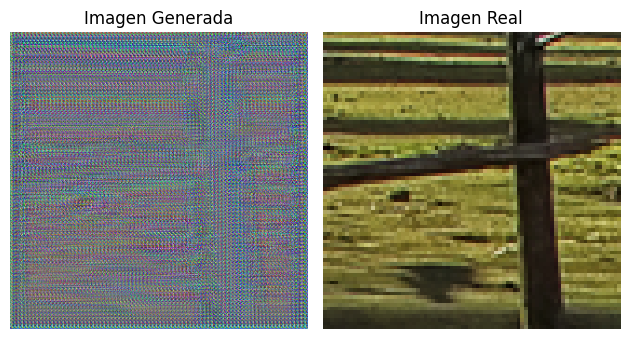

<Figure size 1000x500 with 0 Axes>

In [ ]:
#PROBAMOS EL GENERADOR INCIAL:

from PIL import Image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


#--------------------------------------------------------------------------------------------------------
def show_comparacion(real,generado): #deben de ingrenar don tennoren de imagen generada y real
 print(generado.shape)
 print(real.shape)
 real=real.detach().squeeze().cpu().numpy().transpose(1, 2, 0)
 generado=generado.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
# Primer subgráfico: imagen original
 plt.subplot(1, 2, 1)
 plt.imshow(generado)  # Convertir a NumPy y transponer dimensiones
 plt.title('Imagen Generada')
 plt.axis('off')

# Segundo subgráfico: imagen transformada
 plt.subplot(1, 2, 2)
 plt.imshow(real)  # Convertir a NumPy y transponer dimensiones
 plt.title('Imagen Real')
 plt.axis('off')

# Ajustar el diseño para evitar superposición de títulos
 plt.tight_layout()

# Mostrar la figura
 plt.show()


 plt.figure(figsize=(10, 5))
#-----------------------------------------------------------------------------------
generador=Generador(2).to("cpu")

ruta_imagen = "/content/hr/transformed_0002_1.png"
imagen = Image.open(ruta_imagen)

transformador = ToTensor()

#original iamgen tensor
tensor_imagen = transformador(imagen).unsqueeze(0)
tensor_imagen=tensor_imagen.to("cpu")
#imagen generada
imagen_generada=generador(tensor_imagen)



show_comparacion(tensor_imagen,imagen_generada)

In [ ]:
from torchvision import models

#vamos a extraer los feature es decir las caracteisicas imporantes que exiten entre ambas imagnes y compraralas esto se usara par luego hace rel loss contet apartir del contendio

class Feature_Extractor(nn.Module):
    def __init__(self):
        super(Feature_Extractor, self).__init__()
        # Cargar un modelo VGG-19 preentrenado
        vgg19_model = models.vgg19(pretrained=True).features.eval()

        # No actualizar los pesos del modelo VGG durante el entrenamiento
        for param in vgg19_model.parameters():
            param.requires_grad = False

        selected_layers = list(vgg19_model.children())[:35] #AGREGAMOS EL VGG HASTA VERFICAR QUE EL ULITMA CAPA NO TENGA RELU

        self.vgg=nn.Sequential(*selected_layers)

    def forward(self, img):

        # Extraer características de las imágenes generada y real
        feature_img = self.vgg(img)

        return feature_img


# TV Loss se utiliza comúnmente en tareas de generación de imágenes para reducir el ruido y fomentar la suavidad en las imágenes generadas.

class TVLoss(nn.Module):
  def __init__(self, tv_loss_weight=1):
    super(TVLoss, self).__init__()
    self.tv_loss_weight=tv_loss_weight
  def forward(self, x):
    batch_size=x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]

    count_h = self.tensor_size(x[:, :, 1:, :])
    count_w = self.tensor_size(x[:, :, :, 1:])


    h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
    w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
    return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

  # Forgot to implement an important method
  @staticmethod # Must add this
  def tensor_size(t):
    return t.size()[1] * t.size()[2] * t.size()[3]




In [ ]:
vgg=Feature_Extractor()
print(vgg)
tv_loss= TVLoss()
x=torch.randn(18,3,60,60)
tv_loss=tv_loss(x)

print(tv_loss)

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision.utils as vutils
import sklearn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
# ...

#d=Discriminator(image_dim).to(device)
#g=Generador(dim_vector_ruido,image_dim).to(device)

#d.load_state_dict(torch.load("/content/modelo_gatos_d.pt"))
#g.load_state_dict(torch.load("/content/modelo_gatos_g.pt"))

#d=d.to(device)
#g=g.to(device)


# Supongamos que ya has definido las instancias de los modelos Generador (g) y Discriminador (d),
# y has configurado los optimizadores (g_optimizer y d_optimizer) y la función de pérdida (criterio).



def GAN(discriminador, generador, data_loader_lw,data_loader_hr, num_epochs, batch_size, criterio_g,criterio_d, d_optimizador, g_optimizador, device):

    discriminador=discriminador.to(device)
    generador=generador.to(device)
    feature_extractor=Feature_Extractor().to(device)
    tv_loss= TVLoss().to(device)

    i=0
    for epoch in range(num_epochs):
        for  (lw, hr) in zip(data_loader_lw,data_loader_hr):

            hr_img,hrlbl=hr
            lw_img,lwlbl=lw

            hr_img=hr_img.to(device)
            lw_img=lw_img.to(device)

            generador.eval()
            discriminador.train()

            real_images = hr_img.float()

            real_labels = hrlbl.view(-1, 1).float().to(device)

            # Entrenar el discriminador con imágenes reales
            d_optimizador.zero_grad()

            prediction_real = discriminador(real_images)

            real_loss = criterio_d(prediction_real, real_labels)


            # Entrenar el discriminador con imágenes generadas

            fake_images = generador(lw_img)
            fake_labels = torch.zeros(lw_img.size(0), 1).to(device)

            prediction_fake = discriminador(fake_images)

            fake_loss = criterio_d(prediction_fake, fake_labels).to(device)
            discriminator_loss = (real_loss + fake_loss)/2

            discriminator_loss.backward(retain_graph=True)

            d_optimizador.step()

            # Entrenar el generador
            generador.train()
            discriminador.eval()
            g_optimizador.zero_grad()

            generated_images = generador(lw_img)
            loss_g=criterio_g(discriminador(generated_images),real_labels) #loss del generador aparitr del disicmirnador que dice si es o no una imagen falsa

            loss_imagen=criterio_g(generated_images,real_images) #loss imagen dircamtetne entre igmagen genrada y real

            generated_features=feature_extractor(generated_images)
            real_features=feature_extractor(real_images)
            content_loss=(criterio_g(generated_features, real_features)) #loss de los features original y generado,esto aparitr de el vgg19

            tv_losss=tv_loss(generated_images)
            generator_loss = loss_imagen+content_loss+(0.001*loss_g)+  2e-8*tv_losss  #loss total del generador

            torch.autograd.set_detect_anomaly(True)
            generator_loss.backward()
            g_optimizador.step()

            if i % 100 == 0:
                print(f'Época [{epoch}/{num_epochs}], Paso [{i}/{len(data_loader_lw)}], '
                      f'Pérdida del Discriminador: {discriminator_loss.item():.4f}, '
                      f'Pérdida del Generador: {generator_loss.item():.4f}')
            i=i+1
        # Imprimir estadísticas y visualizar imágenes generadas al final de cada época
        with torch.no_grad():
            generador.eval()
            generated_images = generador(lw_img)

            print(hr_img.shape)
            print(hrlbl[0])
            print(lwlbl[0])
            show_comparacion(hr_img[0],generated_images[0])


#--------------------------------------------------------------------------------------------



num_epochs=25





d=Discriminator()
g=Generador(2)

d.load_state_dict(torch.load("/content/srgan_d.pt"))
g.load_state_dict(torch.load("/content/srgan_g.pt"))

lr_g = 0.00008
lr_d = 0.000008
d_optimizer=optim.Adam(d.parameters(),lr=lr_d)
g_optimizer=optim.Adam(g.parameters(),lr=lr_g)

criterio_d=nn.BCELoss()
criterio_g=nn.MSELoss()


print(f"learning rate discrimiador:{lr_d}")
print(f"learning rate generador:{lr_g}")

GAN(d,g,data_loaderLw,data_loaderHr,num_epochs,batch_size,criterio_g,criterio_d,d_optimizer,g_optimizer,device)




In [ ]:
torch.save(g.state_dict(), 'srgan_g.pt')
torch.save(d.state_dict(), 'srgan_d.pt')

In [ ]:
d.load_state_dict(torch.load("/content/srgan_d.pt"))

torch.Size([1, 3, 1280, 960])


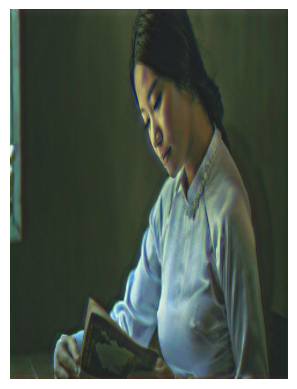

In [ ]:
from PIL import Image
# Suponiendo que "Generador" es la clase de tu generador y "ruta_modelo" es la ruta del modelo guardado
generador = Generador(2)  # creando generado
generador.load_state_dict(torch.load("/content/srgan_g.pt"))
generador.to(device)
generador.eval()

ruta_imagen = "/content/lw_48.png"
imagen_pil = Image.open(ruta_imagen)

transformaciones = transforms.Compose([
    transforms.ToTensor(),  # Convierte la imagen a un tensor

])

imagen_transformada = transformaciones(imagen_pil)
imagen_transformada=imagen_transformada.to(device)
with torch.no_grad():
    generador.eval()

    generated_image = generador(imagen_transformada.unsqueeze(0)).detach().cpu()

# Convertir la imagen al rango [0, 1]
# generated_image = (generated_image + 1) / 2.0

generated_image_np = generated_image.squeeze().permute(1, 2, 0).numpy()

print(generated_image.shape)
# Visualizar la imagen generada
plt.imshow(generated_image_np)
plt.axis('off')
plt.show()


# Convertir el tensor a una imagen
tensor_a_imagen = transforms.ToPILImage()(generated_image.squeeze())

# Guardar la imagen
tensor_a_imagen.save("imagen_guardadahd.jpg")